# Plant Pathology 2020 - EfficientNetB0
https://www.kaggle.com/c/plant-pathology-2020-fgvc7

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

op = os.path.join

In [3]:
import torch 

### CUDA GPU Device Check

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Path

In [5]:
path = "/home/dmsai2/Desktop/AI-Study/PlantPathology2020/"
train_csv = op(path, "train.csv")
train_path = op(path, "images", "Train")

In [6]:
print("train:", len(os.listdir(train_path)))
n_train_data = len(os.listdir(train_path))

train: 1821


In [7]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image

### `read_image_resize()`

In [8]:
import torchvision.transforms as transforms
tf = transforms.ToTensor()

In [9]:
def read_image_resize(img_path, dsize=(224, 224)):
    assert type(dsize) == tuple and len(dsize) == 2
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize)
    tensor_img = tf(img)
    return tensor_img

### `read_image_centercrop`

In [10]:
import albumentations as A

In [11]:
aug_cc = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, always_apply=True),
    
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), rotate_limit=30, p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.CenterCrop(height=1365, width=1365, p=1.0),
    A.Resize(height=224, width=224, p=1)
])

In [12]:
def read_image_centercrop(img_path, dsize=(224, 224)):
    img = cv2.imread(img_path)
    img = aug_cc(image=img)['image']
    tensor_img = tf(img)
    return tensor_img

### Transform for DataLoader

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### PyTorch Customized `Datasets` Class
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [14]:
import torch.nn.functional as F

In [54]:
class PlantPathologyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, header=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = read_image(img_path + '.jpg')

        # read image with resizing to (224, 224)
        image = read_image_resize(img_path + '.jpg')
        
        # read image with centercropping and resize to (224, 224)
        # image = read_image_centercrop(img_path + '.jpg')
        
        # image = cv2.imread(img_path + '.jpg')
    
        label = np.argmax(self.img_labels.iloc[idx, 1:].values)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Load Datasets

In [61]:
dataset = PlantPathologyDataset(train_csv, train_path)#, transform=transform)

### Show Image Example

In [62]:
def show_images(data, is_test=False):
    f, ax = plt.subplots(5, 5, figsize=(15, 10))
    
    for i in range(25):
        img_dir = data.img_labels.iloc[i, 0]
        img_data = cv2.imread(op(train_path, img_dir + '.jpg'))
        label = np.argmax(data.img_labels.iloc[0, 1:].values)
        
        if label  == 0:  str_label = 'healthy'
        elif label == 1:  str_label = 'multiple_diseases'
        elif label == 2: str_label = 'rust'
        else: str_label = 'scab'
        if(is_test): str_label="None"
        
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
        
    plt.show()

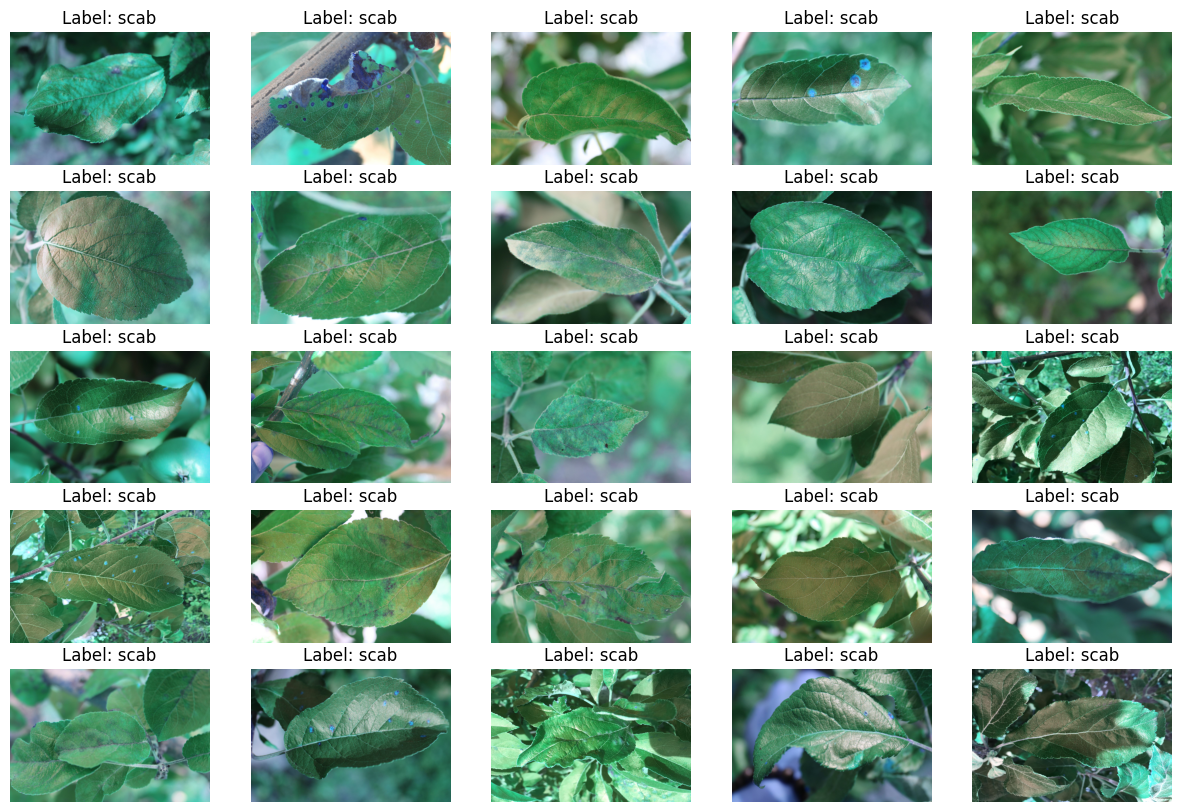

In [40]:
# show_images(dataset)

### Train Test Dataset Split

In [63]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

In [64]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [65]:
print(f"Training Data Size : {len(train_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 1456
Testing Data Size : 365


### Load Dataset

In [66]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 16

In [67]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              drop_last=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=TEST_BATCH_SIZE, 
                             shuffle=True, 
                             drop_last=True)

In [68]:
X_train, y_train = next(iter(train_dataloader))
print(f"Feature batch shape: {X_train.size()}")
print(f"Labels batch shape: {y_train.size()}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


### Activation Function (Swish based ReLU)

In [69]:
def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)

### EfficientNetB0 Model
https://startnow95.tistory.com/4 <br>
https://deep-learning-study.tistory.com/563

In [71]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [87]:
class Conv2dSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [88]:
def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype)  # uniform [0,1)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output

In [89]:
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    """

    def __init__(self, kernel_size, stride, expand_ratio, input_filters, output_filters, se_ratio, drop_n_add):
        super().__init__()
        
        self._bn_mom = 0.1
        self._bn_eps = 1e-03
        self.has_se = (se_ratio is not None) and (0 < se_ratio <= 1)
        self.expand_ratio = expand_ratio
        self.drop_n_add = drop_n_add

        # Filter Expansion phase
        inp = input_filters  # number of input channels
        oup = input_filters * expand_ratio  # number of output channels
        if expand_ratio != 1: # add it except at first block 
            self._expand_conv = Conv2dSamePadding(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = kernel_size
        s = stride
        self._depthwise_conv = Conv2dSamePadding(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise(conv filter by filter)
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1,int(input_filters * se_ratio))  # input channel * 0.25 ex) block2 => 16 * 0.25 = 4
            self._se_reduce = Conv2dSamePadding(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2dSamePadding(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = output_filters
        self._project_conv = Conv2dSamePadding(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        
    def forward(self, inputs, drop_connect_rate=0.2):

        # Expansion and Depthwise Convolution
        x = inputs.to(device)
        if self.expand_ratio != 1:
            x = relu_fn(self._bn0(self._expand_conv(inputs)))
        x = relu_fn(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(relu_fn(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x
            
        # Output phase
        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        if self.drop_n_add == True:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

In [90]:
class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Batch norm parameters
        bn_mom = 0.1
        bn_eps = 1e-03

        # stem
        in_channels = 3
        out_channels = 32
        self._conv_stem = Conv2dSamePadding(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([]) # list 형태로 model 구성할 때
        # stage2 r1_k3_s11_e1_i32_o16_se0.25
        self._blocks.append(MBConvBlock(kernel_size=3, stride=1, expand_ratio=1, input_filters=32, output_filters=16, se_ratio=0.25, drop_n_add=False))
        # stage3 r2_k3_s22_e6_i16_o24_se0.25
        self._blocks.append(MBConvBlock(3, 2, 6, 16, 24, 0.25, False))
        self._blocks.append(MBConvBlock(3, 1, 6, 24, 24, 0.25, True))
        # stage4 r2_k5_s22_e6_i24_o40_se0.25
        self._blocks.append(MBConvBlock(5, 2, 6, 24, 40, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 40, 40, 0.25, True))
        # stage5 r3_k3_s22_e6_i40_o80_se0.25
        self._blocks.append(MBConvBlock(3, 2, 6, 40, 80, 0.25, False))
        self._blocks.append(MBConvBlock(3, 1, 6, 80, 80, 0.25, True))
        self._blocks.append(MBConvBlock(3, 1, 6, 80, 80, 0.25, True))
        # stage6 r3_k5_s11_e6_i80_o112_se0.25
        self._blocks.append(MBConvBlock(5, 1, 6, 80,  112, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 112, 112, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 112, 112, 0.25, True))
        # stage7 r4_k5_s22_e6_i112_o192_se0.25
        self._blocks.append(MBConvBlock(5, 2, 6, 112, 192, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        # stage8 r1_k3_s11_e6_i192_o320_se0.25
        self._blocks.append(MBConvBlock(3, 1, 6, 192, 320, 0.25, False))

        # Head 
        in_channels = 320
        out_channels = 1280
        self._conv_head = Conv2dSamePadding(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._dropout = 0.2
        self._num_classes = 10
        self._fc = nn.Linear(out_channels, self._num_classes)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):          
            x = block(x)
        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        
        # Convolution layers
        x = self.extract_features(inputs).to(device)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

### Build Model

In [91]:
import torchsummary
from torchsummary import summary as summary_
import math

In [92]:
efficientB0 = EfficientNet().to(device)
summary_(efficientB0, (3,224,224))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Neptune AI

In [ ]:
import neptune

In [ ]:
run = neptune.init_run(
    project="leehe228/plant-pathology",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MTRmYjRlNC0zODFlLTQ0ODItODY1MC1hZGQ0YTRhNDNlZjIifQ==",
)

### Params

In [ ]:
params = {
    # lr 1e-3 ~ 1e-6
    "learning_rate": 1e-3,
    "batch_size": BATCH_SIZE,
    "input_size": 3 * 244 * 244,
    "num_epoch": 50,
    "n_classes": 4,
    "optimizer": 'Adam',
    "criterion": 'CrossEntropyLoss',
    "preproc_type": "centercrop",
    "model":"ResNet50",
    "library":"PyTorch",
    "device": str(device)
}
# add parameters
run["parameters"] = params

### Optimizer and Criterion

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(res50.parameters(), lr=params['learning_rate'])

### Metric: ROC AUC

In [ ]:
from torcheval.metrics.aggregation.auc import AUC
from torchmetrics import AUROC

In [ ]:
# metric_auc = AUC()
metric_auc = AUROC(task="multiclass", num_classes=4)

### Learning Scheduler

In [ ]:
# T_max : number of iter
# eta_min : min value of learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, 
                                                       T_max=5, 
                                                       eta_min=1e-6,
                                                       last_epoch=-1,
                                                       verbose=True)

### Training Funcion

In [ ]:
import gc

In [ ]:
def train(model, params, criterion, optimizer):
    for epoch in range(0, params['num_epoch']):
        print(f"epoch {epoch + 1}.")
        
        for i, data in enumerate(train_dataloader, 0):
            # data, label 분리
            x_train, y_train = data
            
            # y_train to one_hot_encoding
            labels = F.one_hot(y_train, num_classes=4).double()
        
            inputs = x_train.to(device)
            labels = labels.to(device)

            # 이전 batch에서 계산된 가중치 초기화
            optimizer.zero_grad()

            # forward + back propagation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # calculate loss, acc, roc auc
            train_loss = criterion(outputs, labels)
            train_acc = (torch.sum(preds == torch.argmax(labels, dim=1))).sum().item() / len(inputs) 
            train_auc = metric_auc(labels, preds).item()
            
            print(f"batch {i}/{n_train_data//BATCH_SIZE} acc:{train_acc}, auc:{train_auc}, loss:{train_loss}")
            
            # training batch loss and accuracy, auc
            run["train/batch/loss"].append(train_loss)
            run["train/batch/acc"].append(train_acc)
            run['train/batch/auc'].append(train_auc)
            
            train_loss.backward()
            optimizer.step()
            metric_auc.reset()
            
        optim_lr = optimizer.param_groups[0]["lr"]
        print(f"learning rate epoch {epoch} : {optim_lr}")
        run["train/epoch/lr"].append(optim_lr)
        
        # scheduler
        scheduler.step()
        
        # empty GPU RAM
        torch.cuda.empty_cache()
        gc.collect()
        
        # test accuracy
        total = 0
        correct = 0
        accuracy = []
        auc = []
        losses = []
        
        for i, data in enumerate(test_dataloader, 0):
            x_train, y_train = data
            
            # y_train to one_hot_encoding
            labels = F.one_hot(y_train, num_classes=4).double()
        
            inputs = x_train.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (torch.sum(preds == torch.argmax(labels, dim=1))).sum().item()
            test_loss = criterion(outputs, labels).item()
            test_auc = (metric_auc(labels, preds)).item()
            test_accuracy = correct / total
        
            run["test/batch/loss"].append(test_loss)
            run["test/batch/acc"].append(test_accuracy)
            run['test/batch/auc'].append(test_auc)
            
            accuracy.append(test_accuracy)
            auc.append(test_auc)
            losses.append(test_loss)
            metric_auc.reset()
        
        # empty GPU RAM
        torch.cuda.empty_cache()
        gc.collect()
        
        num_epochs = params["num_epoch"]
        print(f"epoch: {epoch+1}/{num_epochs}, Test Loss: {np.mean(losses)}, Test Acc: {np.mean(accuracy)}, Test AUC: {np.mean(auc)}")
        print("\n")
        print("="*30)
        
        run["test/epoch/loss"].append(np.mean(losses))
        run["test/epoch/acc"].append(np.mean(accuracy))
        run['test/epoch/auc'].append(np.mean(auc))

In [ ]:
train(efficientB0, params, criterion, optimizer)

In [ ]:
efficientB0.eval()

### Save Model State 

In [ ]:
import torchvision.models as models

In [ ]:
torch.save(efficientB0.state_dict(), 'model_weight_efficientB0_230513(1).pt')

### Submission